# Content and Objectives

- Show construction of eye diagram of modulated signals incl. pulse shaping (rect and raised-cosine) for random data

# Import

In [9]:
# importing
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib


In [10]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=False)

matplotlib.rc('figure', figsize=(24, 10) )


# showing figures inline
%matplotlib inline

# Function for determining the impulse response of an RC filter

In [11]:
# find impulse response of an RC filter
def get_rc_ir(K, n_sps, t_symbol, beta):
    
    ''' 
    Determines coefficients of an RC filter 
    
    Formula out of: K.-D. Kammeyer, Nachrichtenübertragung
    At poles, l'Hospital was used 
    
    NOTE: Length of the IR has to be an odd number
    
    IN: length of IR, upsampling factor, symbol time, roll-off factor
    OUT: filter coefficients
    '''

    # check that IR length is odd
    assert K % 2 == 1, 'Length of the impulse response should be an odd number'
    
    # map zero r to close-to-zero
    if beta == 0:
        beta = 1e-32


    # initialize output length and sample time
    rc = np.zeros( K )
    t_sample = t_symbol / n_sps
    
    
    # time indices and sampled time
    k_steps = np.arange( -(K-1) / 2.0, (K-1) / 2.0 + 1 )   
    t_steps = k_steps * t_sample
    
    for k in k_steps.astype(int):
        
        if t_steps[k] == 0:
            rc[ k ] = 1. / t_symbol
            
        elif np.abs( t_steps[k] ) == t_symbol / ( 2.0 * beta ):
            rc[ k ] = beta / ( 2.0 * t_symbol ) * np.sin( np.pi / ( 2.0 * beta ) )
            
        else:
            rc[ k ] = np.sin( np.pi * t_steps[k] / t_symbol ) / np.pi / t_steps[k] \
                * np.cos( beta * np.pi * t_steps[k] / t_symbol ) \
                / ( 1.0 - ( 2.0 * beta * t_steps[k] / t_symbol )**2 )
 
    return rc

# Parameters

In [12]:
# several parameters

# number of symbols and samples per symbol
n_symb = 1000
n_sps = 8         # samples per symbol

# set time resp. pulse interval and related parameters
t_symb = 1.0 
t_s = t_symb / n_sps                               # sample time



t_min = 0.0
t_max = float( n_symb * t_symb )
t = np.arange(t_min, t_max+t_s, t_s)

t_eye = np.arange(-t_symb/2, t_symb/2+t_s, t_s)

# filter parameters
syms_per_filt = 4  # symbols per filter (plus minus in both directions    
K_filt = 2 * syms_per_filt * n_sps + 1         # length of the fir filter

In [13]:
# function to get constellation and normalize 
def get_constellation( modulation: str ):
    '''
    function pf providing the constellation symbols as list

    IN: intended modulation scheme as string: 'M-MOD'ArithmeticError

    OUT: constellation as numpy array of complex points

    '''
    # find modulation scheme
    M = int( (modulation.partition('-'))[0] )
    mod_scheme = (modulation.partition('-'))[2]  
    
    if mod_scheme == 'ask':
        constellation =  2. * np.arange( 0, M ) - M + 1
        
    elif mod_scheme == 'psk':
        constellation = np.exp( 1j * 2 * np.pi * ( np.arange(1, M+1 ) -1 ) / M )

    elif mod_scheme == 'qam':
        # Gray encoded QAM
        k = int( np.log2( M ) )  

        constellation = np.zeros( M, dtype=complex )

        for m in range( 0, M ):   
            # int to binary string
            b_bin = np.binary_repr(m, width=k)
                
            # map binary to +-1
            b = [ (-1)**(int(x)) for x in b_bin]

            d = np.sqrt(M)/2
            dx = 1
            dy = 1
            s = 0+1j*0
            
            # determine signal point
            for n in np.arange(0, int(k/2)):
                dx *= b[2*n]
                dy *= b[2*n+1]
                s += d*(dx+1j*dy)
                d = d/2;       
                
            constellation[m] = s

    constellation /= np.sqrt( np.average( np.abs( constellation )**2 ) )
    return constellation


In [14]:
# choose modulation and construct constellation points

# choose modulation scheme 
modulation = '2-ask'
# modulation = '16-qam'

constellation = get_constellation ( modulation )


# generate random binary vector and modulate the specified modulation scheme
# find modulation scheme
M = int( (modulation.partition('-'))[0] )

d = np.random.randint( M, size=n_symb)
s = np.array( [ constellation[ data ] for data in d] )

# apply RC filtering/pulse-shaping
# NOTE: Actual filtering will be done later since different RC shapes will be applied
s_up_rc = np.zeros( n_symb * n_sps, dtype=complex )        
s_up_rc[ : : n_sps ] = s

# Show Eye Diagrams

In [15]:
# function for plotting subplots with identical layouts
def get_rc_and_plot_subplot( beta ):
    '''
    plot figures of eye with respective r-value as roll-off factor
    '''
            
    rc = get_rc_ir( K_filt, n_sps, t_symb, beta )
    # rc /= np.linalg.norm( rc ) 
    s_rc = np.convolve( rc, s_up_rc)

    for k in np.arange(3, n_symb-3):
        plt.plot( t_eye, np.real( s_rc[ k * n_sps + n_sps // 2 + (K_filt-1) // 2 : (k+1) * n_sps + n_sps // 2+ (K_filt-1) // 2 + 1 ] ))
    
    plt.grid(True)
    plt.ylabel('Eye(Re\{$\\tilde{h}(t)$\})')        
    plt.title('$\\beta=$'+str(beta))
    plt.axis([-.5, .5, -3, 3])  

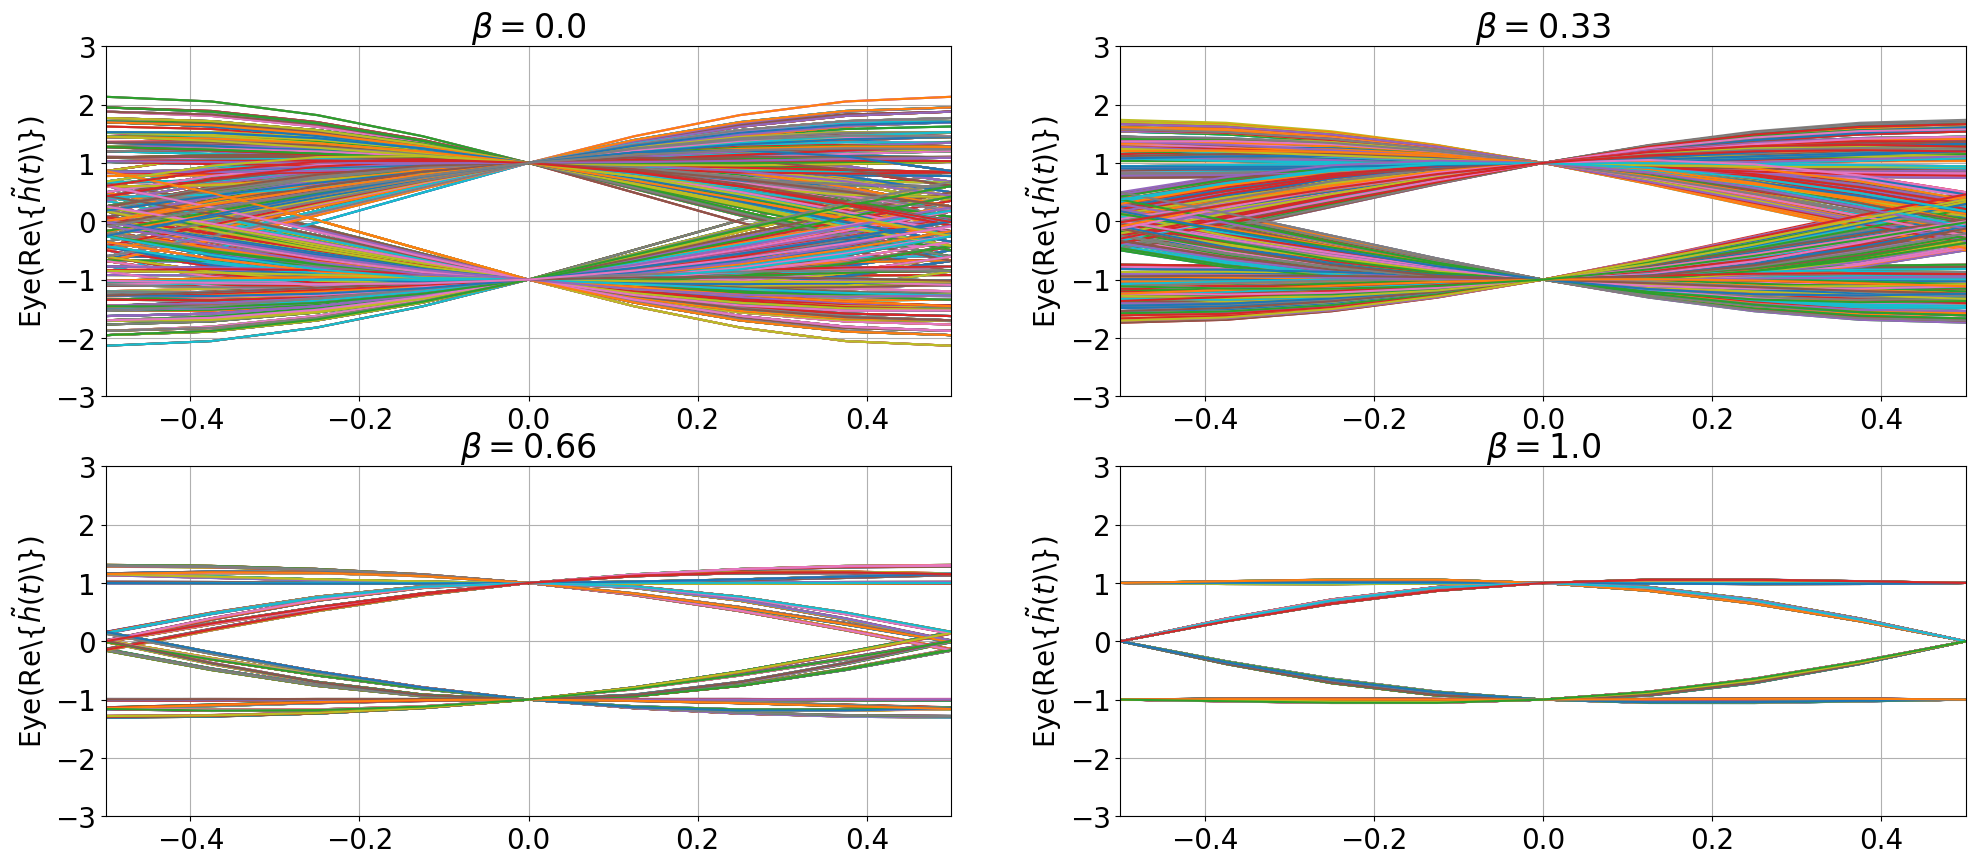

In [16]:
# roll-off factor 0.00    
beta = np.array( [ 0.00, 0.33, 0.66, 1.00] )

for _i in range( 0, 4):
    # plot eye diagram
    # NOTE: picture based on super-imposing relevant parts of the signal
    #       since filtering is used to construct the Tx signal, group delay of the filter has to be considered
    plt.subplot( 2,2, _i + 1 )
    get_rc_and_plot_subplot( beta[ _i  ] )
 
plt.show()